This Jupyter notebook follows the instruction given on https://spatialdata.scverse.org/en/stable/tutorials/notebooks/notebooks/examples/technology_visium_hd.html, which gives out instructions on how to plot Visium HD datasets using python.

Challenges on handling and plotting Visium HD data: \
The data is very sparse. In the dataset used in this notebook, only around 5.5 million of the bins are actually covering parts of the tissue where gene expression is detected. Even within these bins, most of the genes are not expressed. \
\
Raster data: not memory efficient. Fix: decouple spatial locations and gene expression.   
Spatial location: vector geometries (squares). Gene expression info: AnnData table



In [5]:
# reload setup
%load_ext autoreload
%autoreload 2

Typically, we use spatialdata-io to read Visium HD data. Use spatialdata-io to convert to Zarr data. Downloaded (need work on understanding spatialdata-io and conversion to Zarr data)

In [ ]:
# data preparatory work
# data already downloaded
visium_hd_zarr_path = "D:/visium_hd.zarr"

# read the zarr data format
import spatialdata as sd
sdata = sd.read_zarr(visium_hd_zarr_path)
sdata

c:\Users\danie\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\danie\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\danie\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object, with associated Zarr store: D:\visium_hd.zarr
├── Images
│     ├── 'Visium_HD_Mouse_Small_Intestine_cytassist_image': DataArray[cyx] (3, 3000, 3200)
│     ├── 'Visium_HD_Mouse_Small_Intestine_full_image': DataTree[cyx] (3, 21943, 23618), (3, 10971, 11809), (3, 5485, 5904), (3, 2742, 2952), (3, 1371, 1476)
│     ├── 'Visium_HD_Mouse_Small_Intestine_hires_image': DataArray[cyx] (3, 5575, 6000)
│     └── 'Visium_HD_Mouse_Small_Intestine_lowres_image': DataArray[cyx] (3, 558, 600)
├── Shapes
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_002um': GeoDataFrame shape: (5479660, 1) (2D shapes)
│     ├── 'Visium_HD_Mouse_Small_Intestine_square_008um': GeoDataFrame shape: (351817, 1) (2D shapes)
│     └── 'Visium_HD_Mouse_Small_Intestine_square_016um': GeoDataFrame shape: (91033, 1) (2D shapes)
└── Tables
      ├── 'square_002um': AnnData (5479660, 19059)
      ├── 'square_008um': AnnData (351817, 19059)
      └── 'square_016um': AnnData (91033, 19059)
with coordinate syst

In [3]:
# let's make the var names unique; this improves performance in accessing the tabular data and is necessary to be able to plot the data
for table in sdata.tables.values():
    table.var_names_make_unique()

Spatial data object contains several images:  
1 large microscopy image, 2 downscaled version, and 1 CytAssist (for different workflow, used for overlaying data with histological features)  
Also, data at different resolutions (Ann Data)

**Plotting Images**

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Rasterizing image for faster rendering.                                                                   


MemoryError: Unable to allocate 862. MiB for an array with shape (8401, 8965, 3) and data type float32

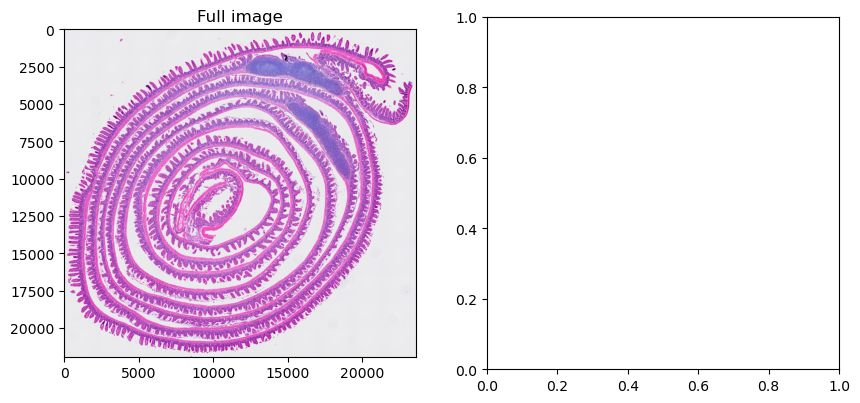

In [10]:
# importing libraries
import matplotlib.pyplot as plt
import spatialdata_plot # used for rendering images method

axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten() # setting up plots

# render 2 images from the sdata object, and plot side by side
# render_images method is used (sdata.pl for plotting class)
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_cytassist_image").pl.show(ax=axes[1], title="CytAssit image")

Issue: want to plot the same range.  
Solution: compute extent of full image, crop the second data (CytAssit) using query methods

In [18]:
# calling get_extent from spatialdata to get the extent (limits) of full image
from spatialdata import get_extent

data_extent = get_extent(sdata["Visium_HD_Mouse_Small_Intestine_full_image"], coordinate_system="global")
data_extent # this returns the min, max of y-coordinate, followed by min, max of x-coordinate

# crop the CytAssit image, using bounding_box_query class
from spatialdata import bounding_box_query

queried_cytassist = bounding_box_query(
    sdata["Visium_HD_Mouse_Small_Intestine_cytassist_image"], # refer to CytAssist image from sdata
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"), # query along x and y axes
    target_coordinate_system="global", 
)
sdata["queried_cytassist"] = queried_cytassist # store it in sdata object

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


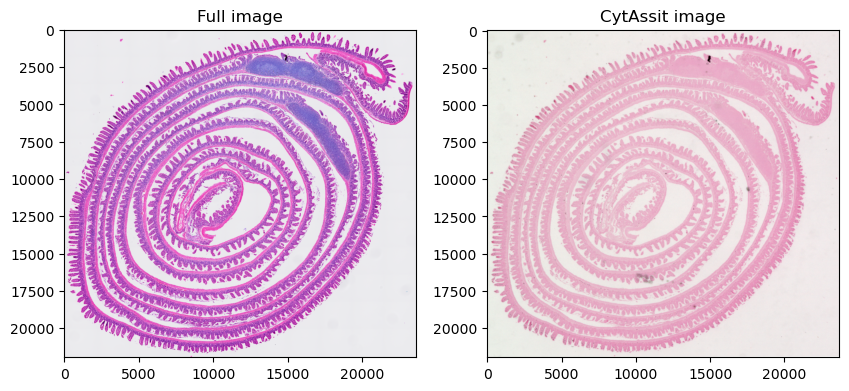

In [13]:
# plot again
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten()
sdata.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show(ax=axes[0], title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show(ax=axes[1], title="CytAssit image")

Visualize on a smaller region: full image shows better resolution

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


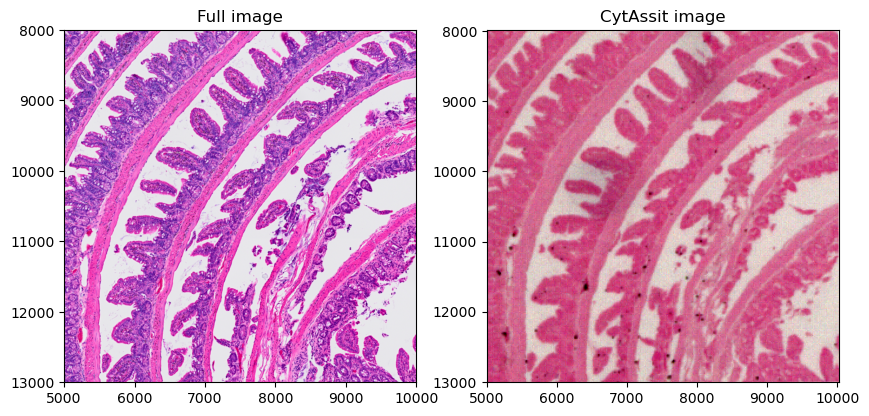

In [26]:
axes = plt.subplots(1, 2, figsize=(10, 5))[1].flatten() # create subplots
crop0 = lambda x: bounding_box_query(
    x, min_coordinate=[5000, 8000], max_coordinate=[10000, 13000], axes=("x", "y"), target_coordinate_system="global" # lambda function to be applied on any input dataset, set min/max coords and axes
)
crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.show( #plot full and cytassist image on a cropped region
    ax=axes[0], title="Full image", coordinate_systems="global"
)
crop0(sdata).pl.render_images("queried_cytassist").pl.show(
    ax=axes[1], title="CytAssit image", coordinate_systems="global"
)

**Plotting Gene Expression Data**

Start: plot bins colored by gene expression. Use large bin size, plot the data in squares

c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   
INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      


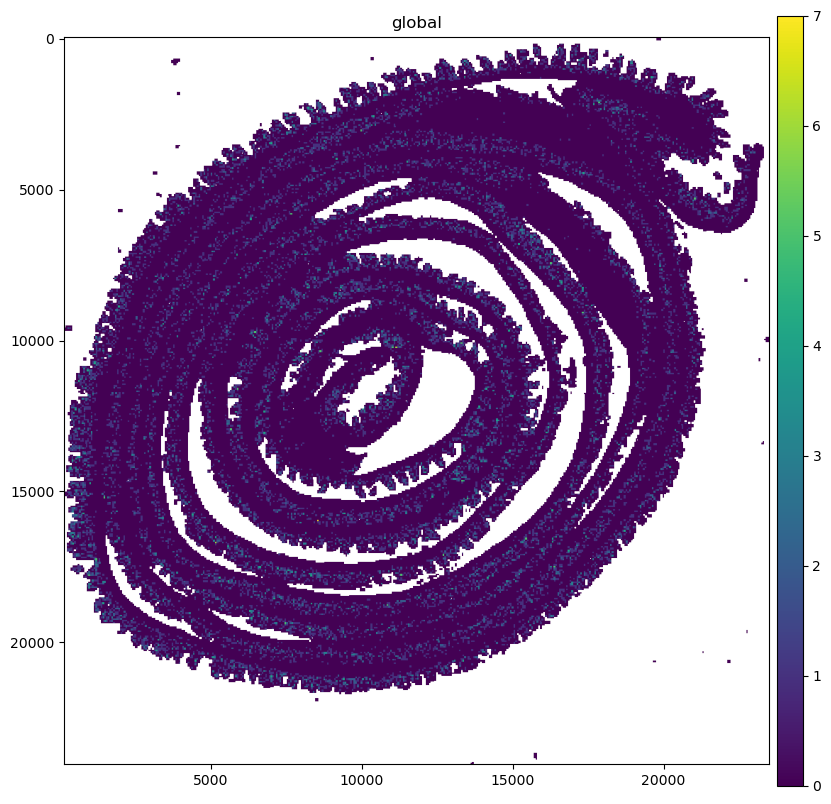

In [8]:
plt.figure(figsize=(10, 10))
ax = plt.gca() # set up plots

gene_name = "AA986860" # visualizing gene name
sdata.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name, method="datashader").pl.show(
    coordinate_systems="global", ax=ax
)
# color = gene_name: specify shapes should be colored based on the expression level of the gene
# datashader: used to render shapes efficiently

On-the-fly data rasterization: (channel-wise rasterization)? uses rasterize_bins() method, produce image objects that can be accessed gene-wise efficiently  
Converts gene expression data into rasterized format - associate gene expression data with spatial coordinates

In [4]:
from spatialdata import rasterize_bins

for bin_size in ["016", "008", "002"]: # iterate across bin sizes - refer to spatial resolutions?
    # rasterize_bins() requires a compresed sparse column (csc) matrix
    sdata.tables[f"square_{bin_size}um"].X = sdata.tables[f"square_{bin_size}um"].X.tocsc() # convert to csc matrix at current binsize (.X refers to the matrix)
    rasterized = rasterize_bins( # converts spatial data into rasterized/pixel grid. Each pixel = spatial bin
        sdata,
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size}um", # name of shape being rasterized
        f"square_{bin_size}um", # name of associated table
        "array_col", # ? defines grid coordinates?
        "array_row",
    )
    sdata[f"rasterized_{bin_size}um"] = rasterized # again, stored back to spatialdata object

IMPORTANT: objects must be computed on the fly (by gene name). Otherwise very slow.

Plotting the rasterized data (short run time, on the fly): (NEED to set scale = full, otherwise will re-rasterize the data)

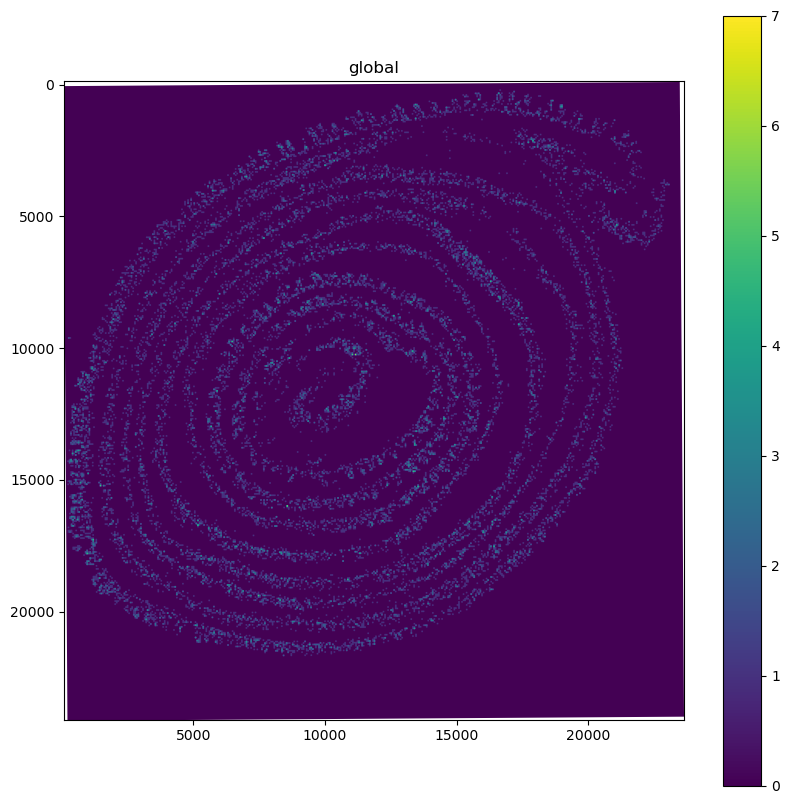

In [9]:
import matplotlib.pyplot as plt
import spatialdata_plot # used for rendering images method
plt.figure(figsize=(10, 10))
ax = plt.gca()

sdata.pl.render_images("rasterized_016um", channel=gene_name, scale="full").pl.show(coordinate_systems="global", ax=ax)

When we try to plot the full data - uniformly violet - because data is sparse and bins are too small. Most non-zero bins are 1 (mess up color).  
Fix: change the limits of the plot to show a portion of the data to avoid interpolation artifacts, plot a binary mask of the full data to avoid the interpolated data to be to close to 0.

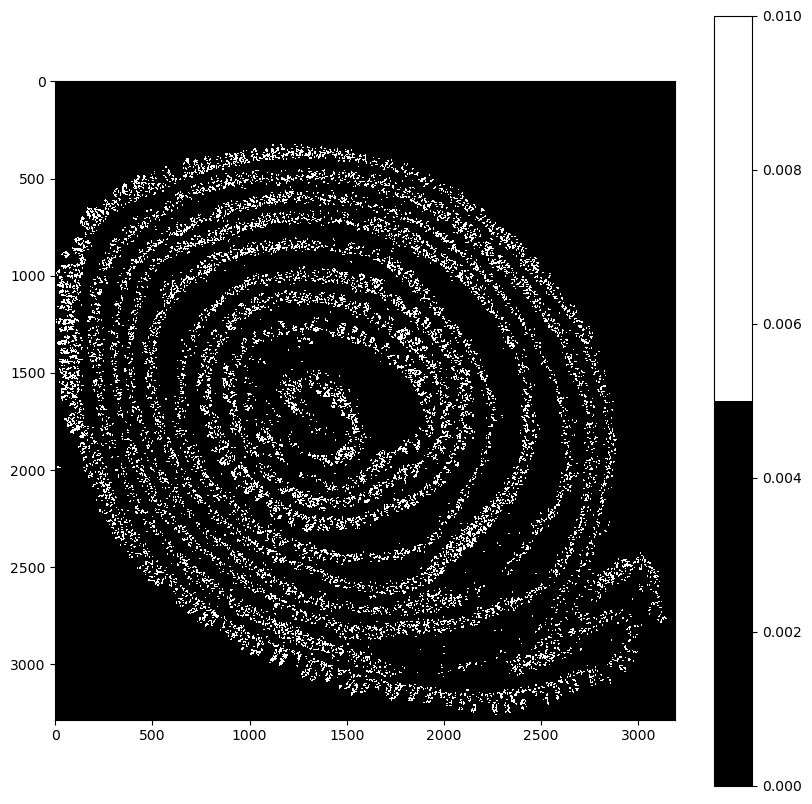

In [10]:
from matplotlib.colors import ListedColormap

# define the colors for the colormap (black for zeros, white for > 0)
colors = ["#000000", "#ffffff"]  # Black, White
cmap = ListedColormap(colors)

plt.figure(figsize=(10, 10))

# bug: interpolation artifact, everything is black with a few sporadic white points: https://github.com/scverse/spatialdata-plot/issues/351
# ax = plt.gca()
# let's set a small vmax value so that the color is white also after interpolation
# sdata.pl.render_images("rasterized_002um", channel=gene_name, scale="full", vmin=0, vmax=0.01, cmap=cmap).pl.show(
# coordinate_systems="global", ax=ax
# )

# ISSUE: Interpolation artifacts cause most of the data to appear black, with sporadic white points. 

# workaround
plt.imshow(sdata["rasterized_002um"].sel(c=gene_name).data.compute(), cmap=cmap, vmin=0, vmax=0.01) # select data of gene = gene_name, fully load data, use customize color map, and map the data range
plt.colorbar()
# will clamp data: anything smaller than min = min

plt.show()

Note this data is rotated (sometimes grid after rasterization is not aligned with horizontal or vertical axis): The advantage of using rasterize_bins() is that the produced object contains the coordinate transformations necessary to align (rotation and scale) the rasterized data together with the high-resolution images.

**Crop and Plotting Subsets**

c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


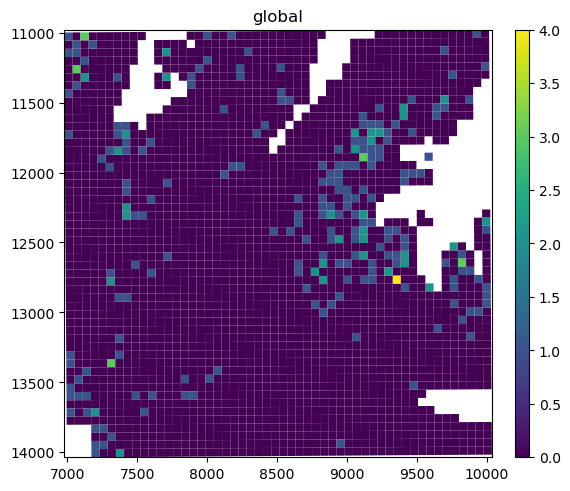

In [11]:
# query, crop, and plot
sdata_small = sdata.query.bounding_box(
    min_coordinate=[7000, 11000], max_coordinate=[10000, 14000], axes=("x", "y"), target_coordinate_system="global"
)
gene_name = "AA986860"
sdata_small.pl.render_shapes("Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name).pl.show(
    coordinate_systems="global"
)

# render_shaped - render geometric shapes or spatial regions, overlay on images

Issue: grid is not axis-aligned, a small rotation exists. Fix: using a data shader to mitigate effects.

INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      


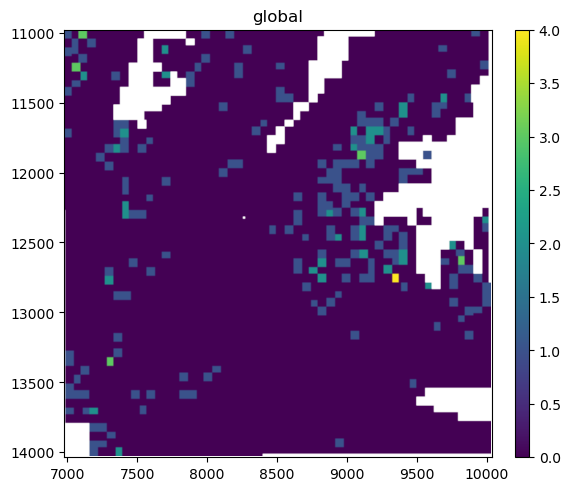

In [12]:
gene_name = "AA986860"
sdata_small.pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color=gene_name, method="datashader"
).pl.show(coordinate_systems="global")

INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      
INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   


c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      


c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_002um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_002um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Using 'datashader' backend with 'sum' as reduction method to speed up plotting. Depending on the reduction
         method, the value range of the plot might change. Set method to 'matplotlib' do disable this behaviour.   
INFO     Using the datashader reduction "sum". "max" will give an output very close to the matplotlib result.      


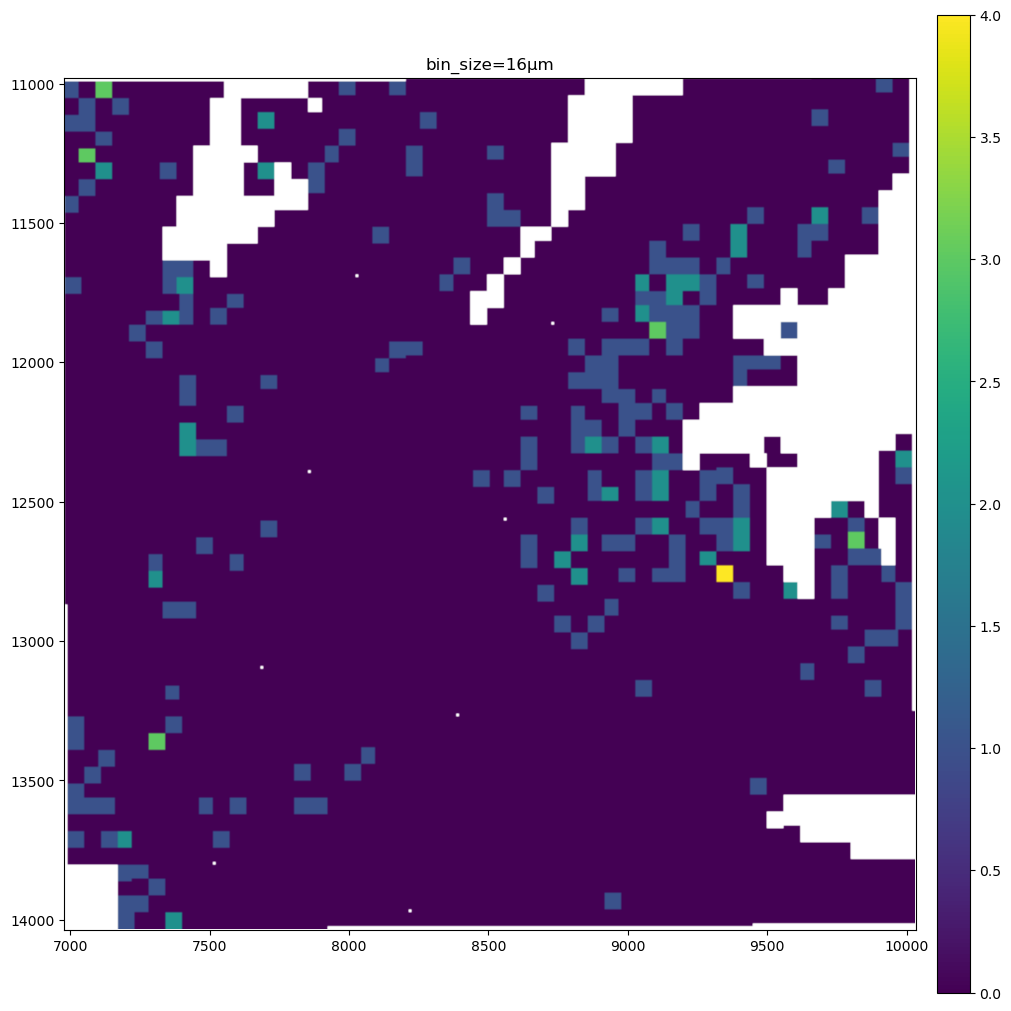

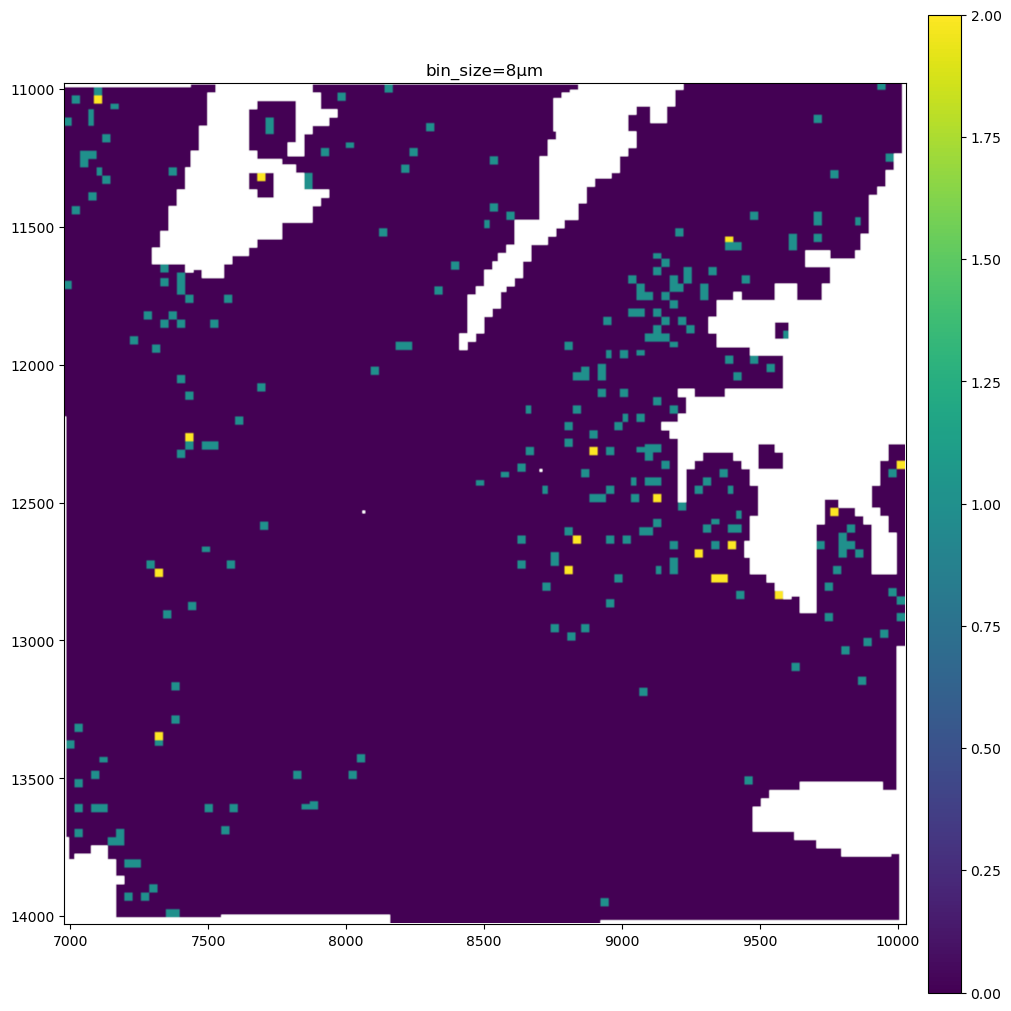

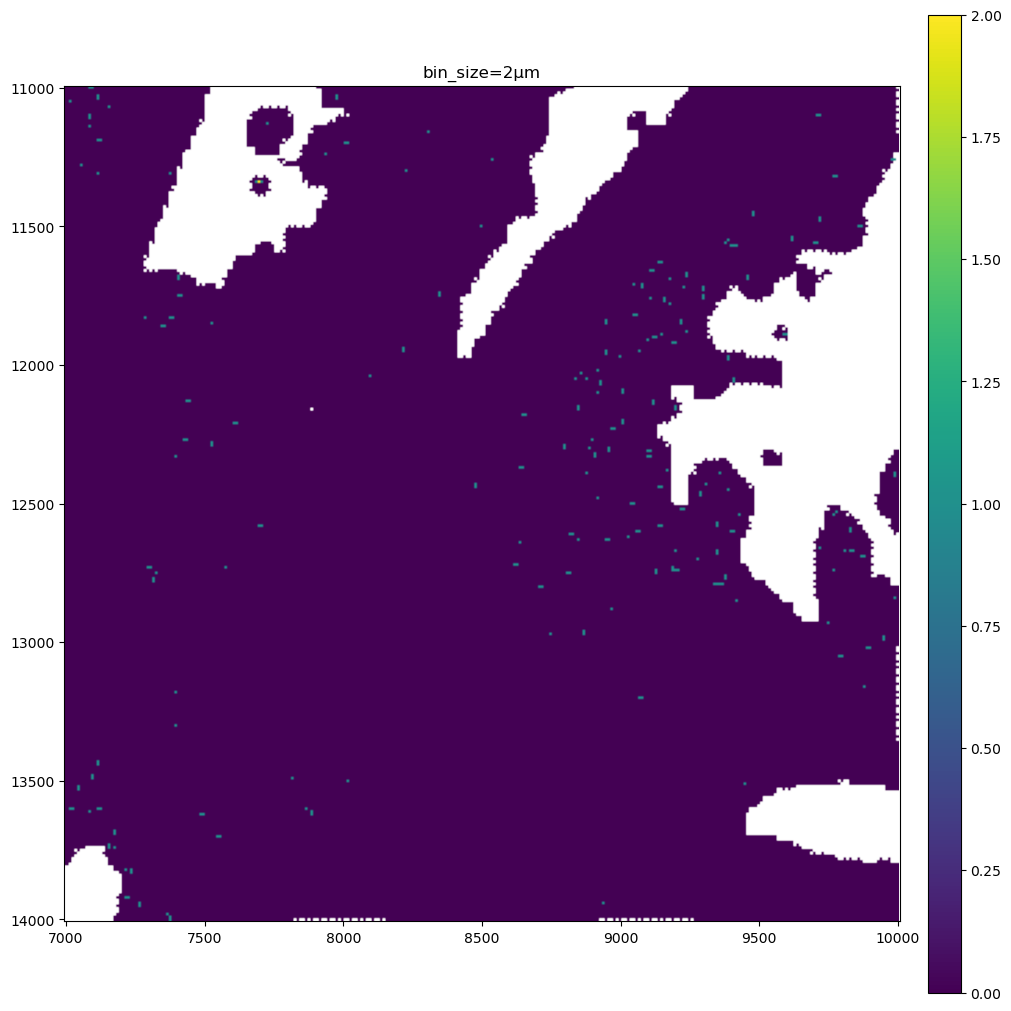

In [13]:
# plotting in different bin sizes
gene_name = "AA986860"

for bin_size in [16, 8, 2]:
    sdata_small.pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um",
        color=gene_name,
        method="datashader",
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

Sparsity observed in images - try to visualize non-zero entries and use full-resolution image as background.  
Solution: modify viridis colormap, 0 plotted as transparent. Highest value will be colored as green (not yellow) as green can contrast with HE image more.

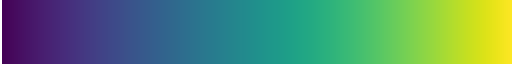

In [14]:
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent

# let's display the areas where no expression is detected as transparent
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")
new_cmap

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: 

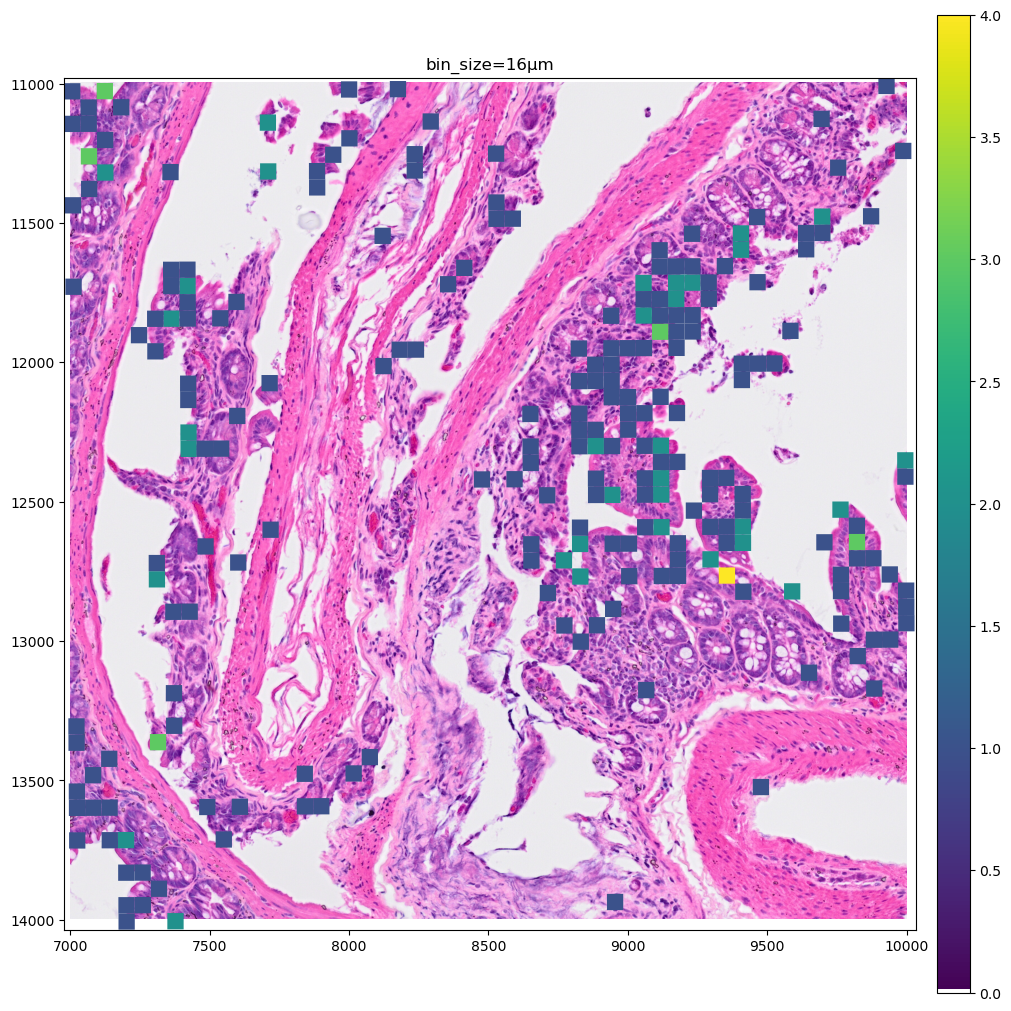

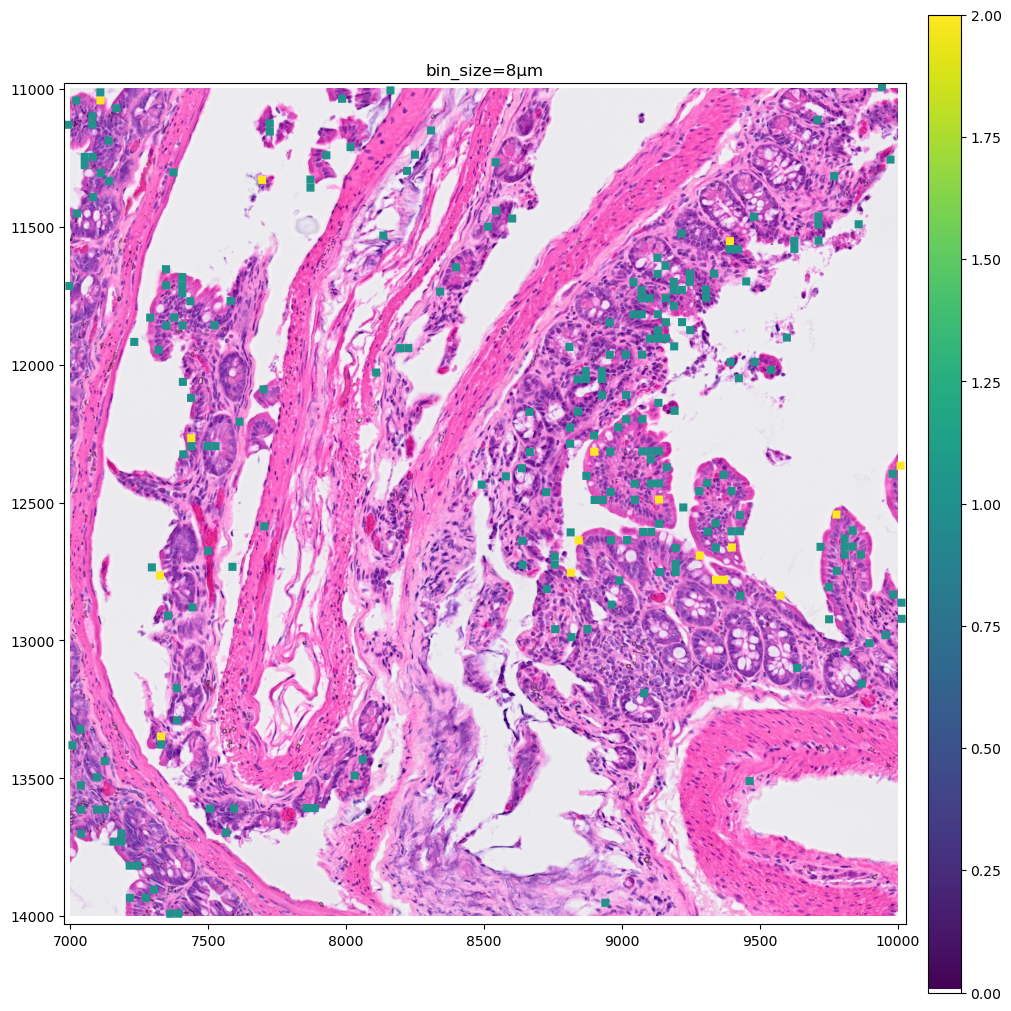

In [15]:
gene_name = "AA986860"
# updated color map
for bin_size in [16, 8]:
    sdata_small.pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
        f"Visium_HD_Mouse_Small_Intestine_square_{bin_size:03}um", color=gene_name, cmap=new_cmap
    ).pl.show(coordinate_systems="global", title=f"bin_size={bin_size}µm", figsize=(10, 10))

c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_002um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_002um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


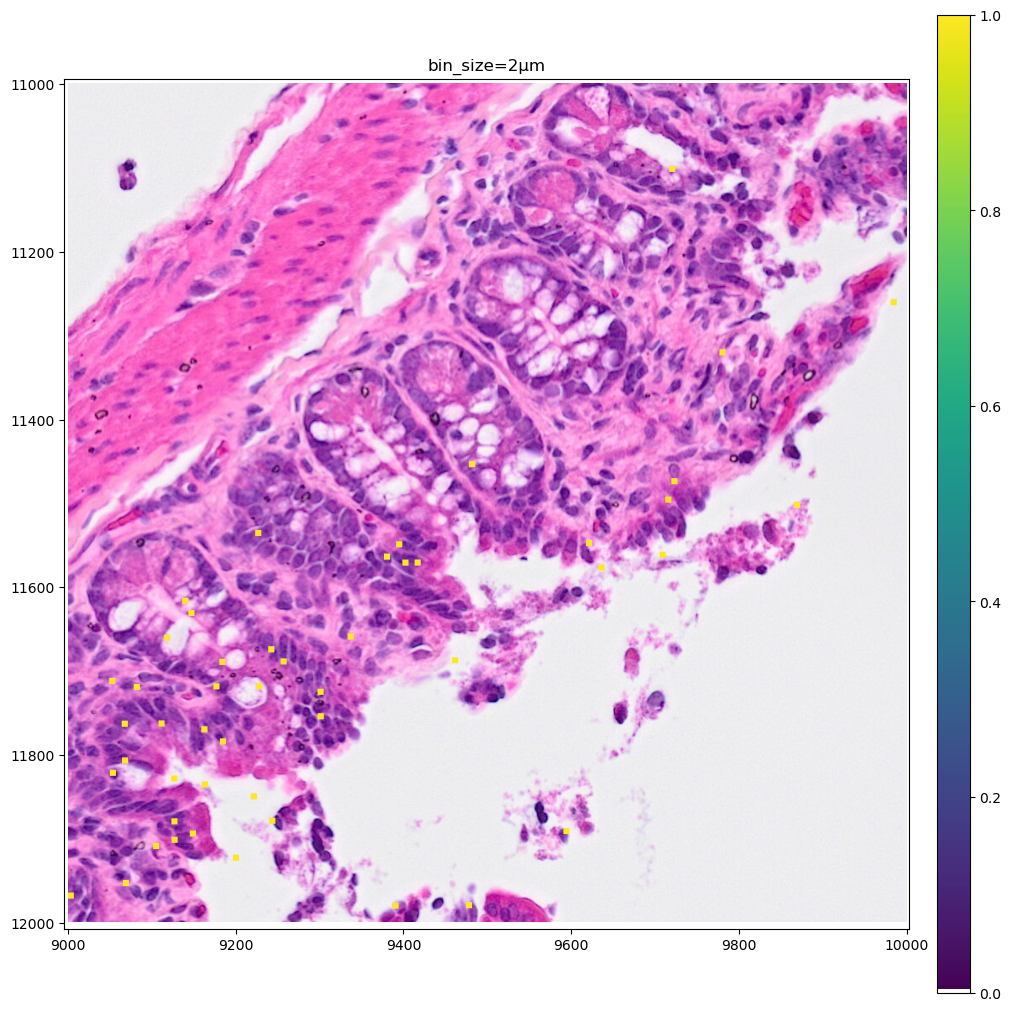

In [19]:
# Zoomed (cropped) version for 2 micrometer bins: need to pass method = matplotlib, otherwise the background cannot be transparent
crop1 = lambda x: bounding_box_query(
    x, min_coordinate=[9000, 11000], max_coordinate=[10000, 12000], axes=("x", "y"), target_coordinate_system="global"
)
crop1(sdata_small).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes( # overlay shapes on images
    "Visium_HD_Mouse_Small_Intestine_square_002um", color=gene_name, cmap=new_cmap, method="matplotlib"
).pl.show(coordinate_systems="global", title=f"bin_size=2µm", figsize=(10, 10))

**Plotting Clusters**

We can color the 16 micrometer bins by cluster identity. Re-used clusters here from 10x genomics.

In [20]:
import os
from tempfile import TemporaryDirectory

import pandas as pd
import requests

# For convenience we rehost the single file containing the clusters we are interested in.
# Let's download it in a temporary directory and read it in a pandas DataFrame. The file is 2 MB.
clusters_file_url = "https://s3.embl.de/spatialdata/misc/visium_hd_mouse_intestine_16um_graphclust.csv"

with TemporaryDirectory() as tmpdir:
    path = os.path.join(tmpdir, "data.csv")
    response = requests.get(clusters_file_url)
    with open(path, "wb") as f:
        f.write(response.content)
    df = pd.read_csv(path)

In [21]:
df.head(3)

Barcode  Cluster
0  s_016um_00144_00175-1        3
1  s_016um_00145_00029-1        7
2  s_016um_00165_00109-1        8

In [22]:
# let's convert the Cluster dtype from int64 to categorical since later we want the plots to use a categorical colormap
df["Cluster"] = df["Cluster"].astype("category") # convert to categorical
df.set_index("Barcode", inplace=True) # set barcode as the index (each row associated with barcode value)

In [23]:
sdata["square_016um"].obs.head(3) # observation table of 16 micrometer dataset

in_tissue  array_row  array_col  location_id  \
s_016um_00144_00175-1          1        144        175            0   
s_016um_00145_00029-1          1        145         29            1   
s_016um_00165_00109-1          1        165        109            2   

                                                             region  
s_016um_00144_00175-1  Visium_HD_Mouse_Small_Intestine_square_016um  
s_016um_00145_00029-1  Visium_HD_Mouse_Small_Intestine_square_016um  
s_016um_00165_00109-1  Visium_HD_Mouse_Small_Intestine_square_016um

In [24]:
# both aligned by index (barcode), so can merge (add new col)
sdata["square_016um"].obs["Cluster"] = df["Cluster"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:105: UserWarning: Key `Visium_HD_Mouse_Small_Intestine_square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata\_core\_elements.py:125: UserWarning: Key `square_016um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
c:\Users\danie\anaconda3\Lib\site-packages\spatialdata_plot\pl\utils.py:771: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


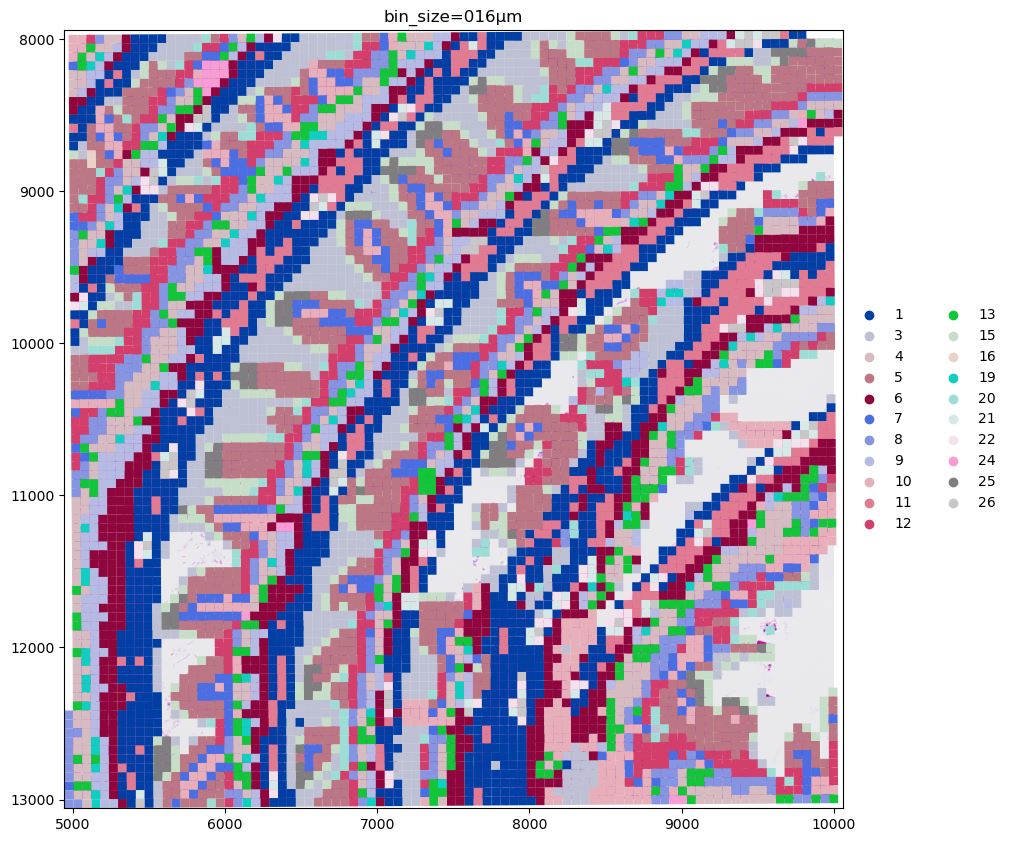

In [27]:
# using cluster information to plot
crop0(sdata).pl.render_images("Visium_HD_Mouse_Small_Intestine_full_image").pl.render_shapes(
    "Visium_HD_Mouse_Small_Intestine_square_016um", color="Cluster"
).pl.show(coordinate_systems="global", title=f"bin_size=016µm", figsize=(10, 10))